# Pet's Facial Expression Detection Using ResNet50

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import imghdr
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
import seaborn as sns

2024-06-19 17:18:09.988812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 17:18:09.988959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 17:18:10.147585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
angry='/kaggle/input/pets-facial-expression-dataset/Angry'
sad='/kaggle/input/pets-facial-expression-dataset/Sad'
happy='/kaggle/input/pets-facial-expression-dataset/happy'

image_exts = ['jpeg', 'jpg', 'png']
def images(folder):
    images=[]
    for file in os.listdir(folder):
        img=(os.path.join(folder,file))
        if((imghdr.what(img) in image_exts)):
            img=cv2.imread(img,cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(224,224))
            images.append(img)
    return images
angry_img=images(angry)
happy_img=images(happy)
sad_img=images(sad)

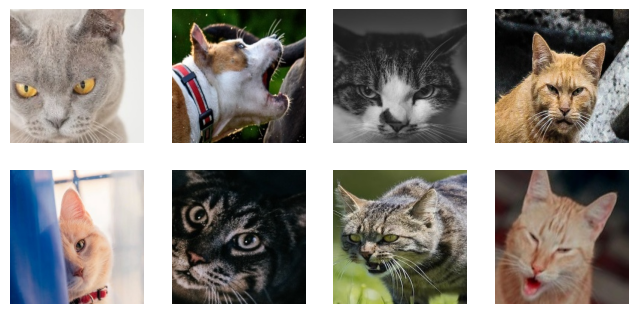

In [3]:
plt.figure(figsize=(8,8))
for i,file in enumerate (os.listdir(angry),1):
    img=os.path.join(angry,file)
    img=plt.imread(img)
    plt.subplot(4,4,i)
    plt.imshow(img)
    plt.axis('off')
    if(i==8):
        break

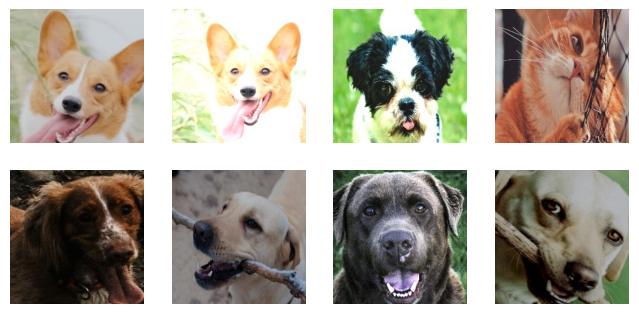

In [4]:
plt.figure(figsize=(8,8))
for i,file in enumerate (os.listdir(happy),1):
    img=os.path.join(happy,file)
    img=plt.imread(img)
    plt.subplot(4,4,i)
    plt.imshow(img)
    plt.axis('off')
    if(i==8):
        break

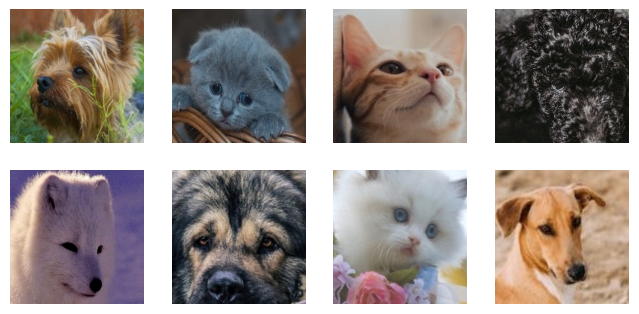

In [5]:
plt.figure(figsize=(8,8))
for i,file in enumerate (os.listdir(sad),1):
    img=os.path.join(sad,file)
    img=plt.imread(img)
    plt.subplot(4,4,i)
    plt.imshow(img)
    plt.axis('off')
    if(i==8):
        break

In [6]:
# Creating labels for each category
happy_labels = [0] * len(happy_img)
sad_labels = [1] * len(sad_img)
angry_labels = [2] * len(angry_img)

X = np.array(happy_img+sad_img+angry_img)
y = np.array(happy_labels + sad_labels + angry_labels)
X = X.astype('float32') / 255.0

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

In [9]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

In [10]:
from keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)

In [11]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [12]:
ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [13]:
def Create_ResNet50V2_Model():
    model = Sequential([
        ResNet50V2,
        GlobalAveragePooling2D(),
        Dropout(0.25),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

In [14]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 16,352,256 (62.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [15]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=10,
                          restore_best_weights=True)
history = model.fit(
    X_train, y_train_onehot,
    epochs=20,
    validation_data=(X_val, y_val_onehot),
    callbacks=[earlystop]
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.9038 - loss: 0.3308 - val_accuracy: 0.3958 - val_loss: 677.4283
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.8888 - loss: 0.3640 - val_accuracy: 0.4062 - val_loss: 28.2921
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9144 - loss: 0.2413 - val_accuracy: 0.3854 - val_loss: 143.3282
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9239 - loss: 0.2117 - val_accuracy: 0.3854 - val_loss: 86.1999
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9795 - loss: 0.0755 - val_accuracy: 0.4167 - val_loss: 18.6444
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9842 - loss: 0.0452 - val_accuracy: 0.5000 - val_loss: 13.6924
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9935 - loss: 0.0360 - val_accuracy: 0.5417 - val_loss: 6.8298
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9900 - loss: 0.0618 - val_accuracy: 0.4792 - v

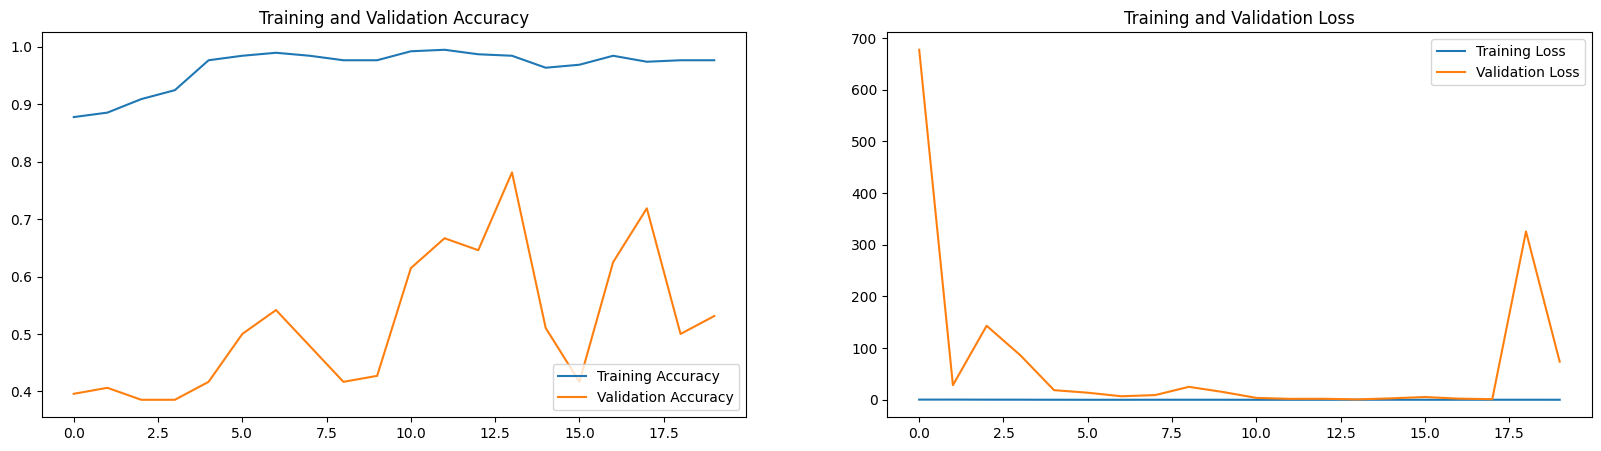

In [18]:
plot_training_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


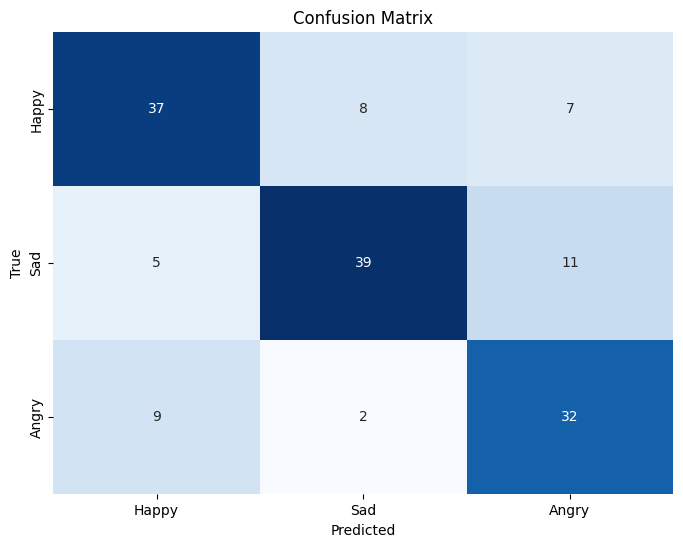

''

In [19]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Happy', 'Sad', 'Angry'], yticklabels=['Happy', 'Sad', 'Angry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
''

In [21]:
model.save_weights('ResNet.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


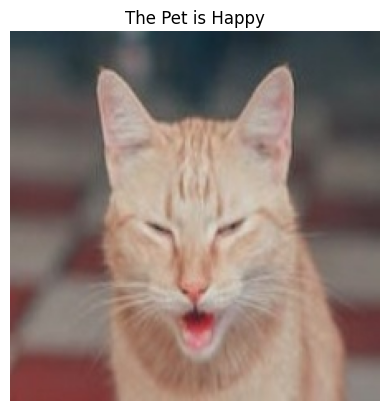

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


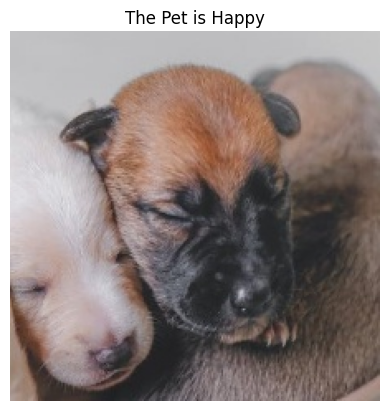

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


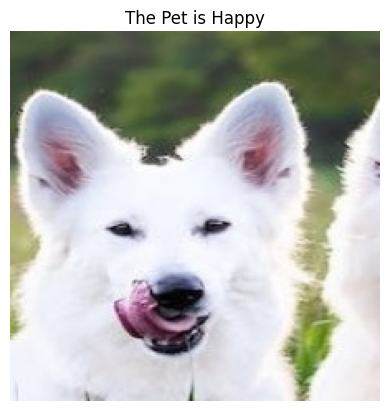

In [24]:
def predict_and_display(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    class_indices = {'Happy': 0, 'Sad': 1, 'Angry': 2}  # Adjust this dictionary as needed
    class_labels = list(class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"The Pet is {predicted_class_label}")
    plt.show()

model.load_weights('/kaggle/working/ResNet.weights.h5')

image_path_to_test = '/kaggle/input/pets-facial-expression-dataset/Angry/02.jpg'
predict_and_display(image_path_to_test, model)

image_path_to_test = '/kaggle/input/pets-facial-expression-dataset/Sad/031.jpg'
predict_and_display(image_path_to_test, model)

image_path_to_test = '/kaggle/input/pets-facial-expression-dataset/happy/032.jpg'
predict_and_display(image_path_to_test, model)